# Using pretrained ResNet150 in CIFAR100

In [ ]:
import torch
import torch.nn as nn
import torchvision as tv
from torchvision import transforms,datasets,models
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu');device

'cuda:0'

### Extract Data


In [ ]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [4]:
trainset = datasets.CIFAR100('.',train=True,transform=tfms,download=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=100,shuffle=True)

testset = datasets.CIFAR100('.',train=False,transform=tfms,download=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=100,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = trainloader.dataset.classes

In [6]:
np.bincount(trainloader.dataset.targets)

array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 500])

In [7]:
np.bincount(testloader.dataset.targets)

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100])

mouse maple_tree dinosaur flatfish plate   ray whale spider couch castle shark   ray clock  worm telephone tulip tiger castle flatfish cattle plain train cockroach couch   bee  rose spider spider   cup couch sweet_pepper orange pickup_truck orange table pickup_truck raccoon television bottle bridge sunflower pickup_truck poppy streetcar  crab house wardrobe flatfish  girl  rose kangaroo crocodile beetle  bear pine_tree woman castle   sea hamster trout palm_tree oak_tree maple_tree squirrel turtle  bear lawn_mower   bed lizard dinosaur  tank sweet_pepper  rose dinosaur  pear   sea mountain squirrel hamster rocket flatfish   bee porcupine   bee shrew dolphin whale willow_tree  tank  crab   can bottle rabbit apple streetcar couch trout beetle possum   bee


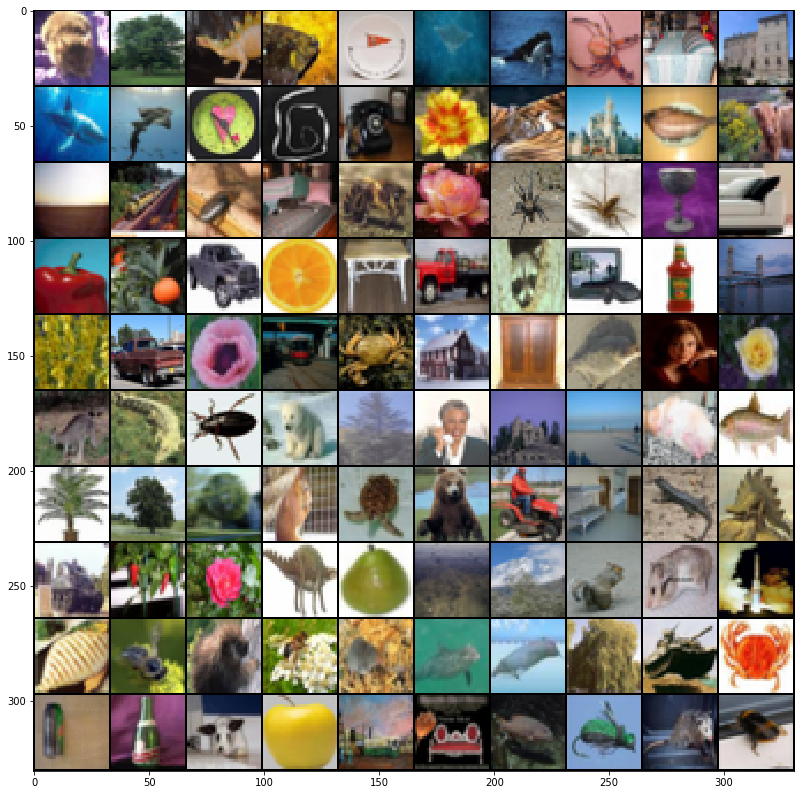

In [8]:
batch = next(iter(trainloader))
img,label = batch

imgs = tv.utils.make_grid(img,nrow=10,padding=1,normalize=True)
print(" ".join('%5s' % classes[label[j]] for j in range(100)))
plt.figure(figsize=(14,14))
plt.imshow(imgs.permute(1,2,0))

### Load ResNet152 network and replace FC layers

In [ ]:
net = models.resnet152(pretrained=True)

In [10]:
net.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
net.fc = nn.Linear(in_features=2048, out_features=100, bias=True)

In [ ]:
for param in net.parameters():
    param.requires_grad=False
net.eval()
net.fc.weight.requires_grad=True
net.fc.bias.requires_grad=True

In [13]:
net.conv1.weight.requires_grad,net.fc.bias.requires_grad

(False, True)

In [ ]:
net = net.to(device)

### Train the Network

In [ ]:
def accuracy(net,dataloader):
    with torch.no_grad():
        correct=0
        total=0
        for batch in dataloader:
            X,y = batch
            X,y = X.to(device),y.to(device)
            predict = net(X)
            for idx,i in enumerate(predict):
                if torch.argmax(i)==y[idx]:
                    correct+=1
                total+=1
    accuracy = round(correct/total*100,5)
    print('Accuracy: {}'.format(accuracy))
    return accuracy


In [ ]:
def learn(net,trainloader,testloader,epochs,lr):
    losses = []
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(filter(lambda p:p.requires_grad,net.parameters()),lr=lr,momentum=0.9)

    for epoch in range(1,epochs+1):
        e=[]
        for b,batch in enumerate(trainloader):
            optimizer.zero_grad()
            img,label = batch
            img,label = img.to(device),label.to(device)
            output = net(img)
            loss = loss_fun(output,label)
            loss.backward()
            losses.append([epoch,b,loss.item()])
            e.append(loss.item())
            optimizer.step()
        
        # acc_train = accuracy(net,trainloader)
        if epoch%(epochs/5)==0: acc_test = accuracy(net,testloader)
        # with torch.no_grad():
        #     correct = 0
        #     total = 0
        #     for batch_t in testloader:
        #         X,y = batch_t
        #         X,y = X.to(device), y.to(device)
        #         predict = net(X)
        #         for idx,i in enumerate(predict):
        #             if torch.argmax(i) == y[idx]:
        #                 correct += 1
        #             total += 1
        # accuracy = round(correct/total*100,5)
        # if accuracy ==100: torch.save(net.state_dict(),'./100P.pt')
        print('Epoch:{} Train.Loss:{}'.format(epoch,np.mean(e)))
    return losses

In [19]:
losses = learn(net,trainloader,testloader,30,1e-1)

Epoch:1 Train.Loss:15.587872528076172
Epoch:2 Train.Loss:15.245453401565552
Epoch:3 Train.Loss:14.889610269546509
Epoch:4 Train.Loss:13.85252686882019
Epoch:5 Train.Loss:13.560607846260071
Accuracy: 34.17
Epoch:6 Train.Loss:13.548725538253784
Epoch:7 Train.Loss:12.766276293754578
Epoch:8 Train.Loss:12.32310184955597
Epoch:9 Train.Loss:11.636498204231263
Epoch:10 Train.Loss:11.346399384498596
Epoch:11 Train.Loss:11.048124001502991
Accuracy: 35.91
Epoch:12 Train.Loss:10.892368168830872
Epoch:13 Train.Loss:10.79952920627594
Epoch:14 Train.Loss:10.344123421669007
Epoch:15 Train.Loss:10.22174760913849
Epoch:16 Train.Loss:9.993978351593018
Epoch:17 Train.Loss:9.7922348985672
Accuracy: 35.61
Epoch:18 Train.Loss:9.285658335208893
Epoch:19 Train.Loss:9.374490426063538
Epoch:20 Train.Loss:9.371237927436828
Epoch:21 Train.Loss:8.970336219787598
Epoch:22 Train.Loss:8.733656292915343
Epoch:23 Train.Loss:8.570997878074646
Accuracy: 36.06
Epoch:24 Train.Loss:8.288732340335846
Epoch:25 Train.Loss:8.05

In [61]:
net.load_state_dict(torch.load('100P.pt'))

<All keys matched successfully>

In [78]:
accuracy(net,trainloader)

100%|██████████| 500/500 [00:35<00:00, 14.34it/s]

Accuracy: 98.692


98.692

In [77]:
accuracy(net,testloader)

100%|██████████| 100/100 [00:07<00:00, 13.78it/s]

Accuracy: 38.73


38.73

# Try with my Own CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,32,3,stride=1,padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(32,32,3,stride=1,padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.Conv2d(32,32,3,stride=1,padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(32,32,3,stride=1,padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(4,4))
        self.fc1 = nn.Sequential(nn.Linear(32*8*8,512),
                                    nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(512,100))
    
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

m = Net().to(device)

In [85]:
m(img.to(device)).shape

torch.Size([100, 100])

In [86]:
mL= learn(m,trainloader,trainloader,100,1e-3)

Epoch:1 Train.Loss:4.072582896709442
Epoch:2 Train.Loss:3.3423606333732603
Epoch:3 Train.Loss:2.9300630989074707
Epoch:4 Train.Loss:2.6124481801986694
Epoch:5 Train.Loss:2.3984638235569
Epoch:6 Train.Loss:2.235879063129425
Epoch:7 Train.Loss:2.1077821822166443
Epoch:8 Train.Loss:1.9962444322109223
Epoch:9 Train.Loss:1.8912079100608825
Epoch:10 Train.Loss:1.8000814599990844
Epoch:11 Train.Loss:1.7065766472816468
Epoch:12 Train.Loss:1.6175136165618897
Epoch:13 Train.Loss:1.5353182849884033
Epoch:14 Train.Loss:1.4545594158172608
Epoch:15 Train.Loss:1.370662516593933
Epoch:16 Train.Loss:1.2905119242668153
Epoch:17 Train.Loss:1.2124791383743285
Epoch:18 Train.Loss:1.1357235910892487
Epoch:19 Train.Loss:1.0493906084299087
Accuracy: 76.626
Epoch:20 Train.Loss:0.9749266855716705
Epoch:21 Train.Loss:0.8986753723621368
Epoch:22 Train.Loss:0.823433240890503
Epoch:23 Train.Loss:0.7503375905156136
Epoch:24 Train.Loss:0.6767242609858513
Epoch:25 Train.Loss:0.608475182056427
Epoch:26 Train.Loss:0.538

In [ ]:
mL = torch.tensor(mL)

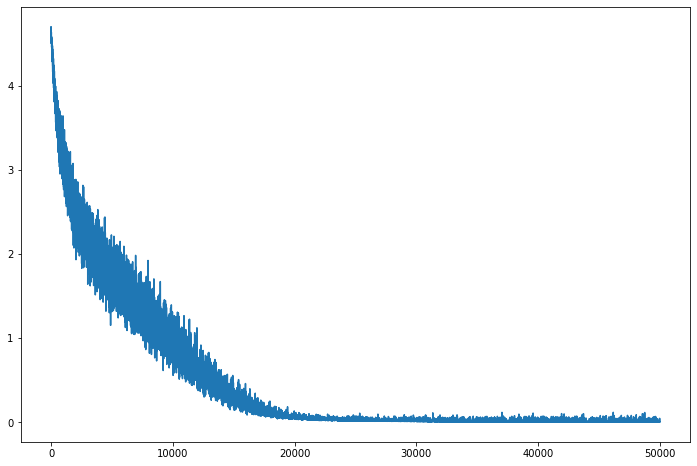

In [99]:
plt.figure(figsize=(12,8))
plt.plot(mL[:,2])

In [100]:
accuracy(m,testloader)

Accuracy: 44.33


44.33